# Virtual Lead Qualifier – Lead Scoring (Final Clean Notebook)

Notebook with experimentation, cross-validation, and final model selection.

## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

#Basic Setting
pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix

## 2. Load Dataset

In [3]:
df = pd.read_csv("Lead Scoring.csv")
df.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


## 3. Data Cleaning & Leakage Control

In [5]:
df.drop(columns=["Prospect ID", "Lead Number", "Lead Quality"], inplace=True)

num_cols = [
    "TotalVisits", "Page Views Per Visit",
    "Asymmetrique Activity Score", "Asymmetrique Profile Score"
]
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

cat_cols = [
    "Last Activity", "Country", "Specialization",
    "How did you hear about X Education",
    "What is your current occupation",
    "What matters most to you in choosing a course",
    "Lead Profile", "City"
]
for col in cat_cols:
    df[col].fillna("Unknown", inplace=True)

## 4. Binary Encoding

In [7]:
binary_cols = [
    "Do Not Email", "Do Not Call", "Search", "Magazine",
    "Newspaper Article", "X Education Forums", "Newspaper",
    "Digital Advertisement", "Through Recommendations",
    "Receive More Updates About Our Courses",
    "Update me on Supply Chain Content", "Get updates on DM Content",
    "I agree to pay the amount through cheque",
    "A free copy of Mastering The Interview"
]

for col in binary_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.strip()
        .str.lower()
        .map({"yes": 1, "no": 0})
        .fillna(0)   # 👈 future-proof line
    )

## 5. Lead Source Grouping

In [11]:
df["Lead Source"].fillna(df["Lead Source"].mode()[0], inplace=True)

top_sources = ["Google", "Direct Traffic", "Organic Search", "Facebook", "Olark Chat"]
df["Lead Source"] = df["Lead Source"].apply(lambda x: x if x in top_sources else "Other")

## 6. Intent Feature from Tags

In [16]:
def tag_group(tag):
    if pd.isna(tag):
        return "Unknown"
    elif "Interested" in tag:
        return "High Intent"
    elif tag in ["Busy", "Ringing"]:
        return "Medium Intent"
    else:
        return "Low Intent"

df["Tag_Group"] = df["Tags"].apply(tag_group)

df.drop(columns=["Tags", "Asymmetrique Activity Index", "Asymmetrique Profile Index"], inplace=True)

## 7. Train–Test Split

In [19]:
X = df.drop("Converted", axis=1)
y = df["Converted"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

## 8. Preprocessing Pipeline

In [22]:
categorical_cols = X.select_dtypes(include="object").columns
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols),
    ("num", StandardScaler(), numeric_cols)
])

## 9. Baseline Model – Logistic Regression

In [25]:
baseline_clf = Pipeline([
    ("preprocessing", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

baseline_clf.fit(X_train, y_train)
baseline_prob = baseline_clf.predict_proba(X_test)[:, 1]

print("Baseline ROC-AUC:", roc_auc_score(y_test, baseline_prob))

Baseline ROC-AUC: 0.9380047058254646


## 10. Cross-Validation – Model Stability (Gradient Boosting)

In [28]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gb_cv_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", GradientBoostingClassifier(random_state=42))
])

cv_scores = cross_val_score(
    gb_cv_pipeline,
    X, y,
    cv=cv,
    scoring="roc_auc"
)

print("CV ROC-AUC scores:", cv_scores)
print("Mean:", cv_scores.mean())
print("Std:", cv_scores.std())

CV ROC-AUC scores: [0.95879305 0.96645966 0.95660595 0.95493254 0.95807687]
Mean: 0.9589736146647629
Std: 0.003970232570636778


## 11. Final Model Training – Gradient Boosting

In [30]:
final_clf = Pipeline([
    ("preprocessing", preprocessor),
    ("model", GradientBoostingClassifier(random_state=42))
])

final_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['Lead Origin', 'Lead Source', 'Last Activity', 'Country',
       'Specialization', 'How did you hear about X Education',
       'What is your current occupation',
       'What matters most to you in choosing a course', 'Lead Profile', 'City',
       'Last Notable Activity', 'Tag_Gr...
       'Magazine', 'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations',
       'Receive More Updates About Our Courses',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'Asymmetrique Activity Score', 'Asymmetrique Profile Score',
       'I agree to pay the amount through cheque',
       'A free copy of Mastering The Interview'],
      dtype='object'))])),
                ('model', GradientBoostingClassifier(random_state=42))])

## 12. Final Evaluation

Final ROC-AUC: 0.9576412516924266
[[1587  117]
 [ 166  902]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1704
           1       0.89      0.84      0.86      1068

    accuracy                           0.90      2772
   macro avg       0.90      0.89      0.89      2772
weighted avg       0.90      0.90      0.90      2772



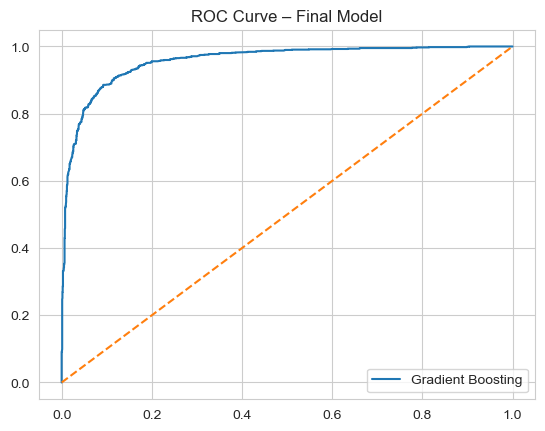

In [32]:
y_prob = final_clf.predict_proba(X_test)[:, 1]

print("Final ROC-AUC:", roc_auc_score(y_test, y_prob))
print(confusion_matrix(y_test, (y_prob >= 0.5).astype(int)))
print(classification_report(y_test, (y_prob >= 0.5).astype(int)))

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label="Gradient Boosting")
plt.plot([0,1],[0,1],'--')
plt.legend()
plt.title("ROC Curve – Final Model")
plt.show()

## 13. Lead Scoring & Bucketing

In [48]:
lead_score = pd.Series((y_prob * 100).round(0), index=y_test.index)

def lead_bucket(score):
    if score >= 80:
        return "Hot Lead"
    elif score >= 60:
        return "Warm Lead"
    else:
        return "Cold Lead"

lead_output = pd.DataFrame({
    "Lead_Score": lead_score,
    "Lead_Category": lead_score.apply(lead_bucket),
    "Actual_Converted": y_test
})

lead_output.head()
#lead_output.sort_values(by="Lead_Score", ascending=False).head()

,Lead_Score,Lead_Category,Actual_Converted
8305,5.0,Cold Lead,0
1591,90.0,Hot Lead,1
8604,78.0,Warm Lead,0
1333,4.0,Cold Lead,0
4260,2.0,Cold Lead,0


## 14. Save Model

In [29]:
#joblib.dump(final_clf, "lead_scoring_model.joblib")